Problem description:
A taxi was going from point A to point B in NY city, at a certain time on a given day, can you predict how long the trip was? Train/test sets containing info. of past trips are provided by two Taxi companies.

Highlights:
* Feature analysis:
    1-D/2-D histogram with log scale and/or normalization to spot outliers.
* Feature engineering: 
    Use Haversine to estimate great-circle distance of earth, to approximate trip length.
    Use Pandas datetime methods to generate time features.
    Use the poweful pandas groupby() to generate insights.
    Use Mini-batch Kmeans for large data clustering.
* Modeling:
    Use XGBoost for training/validation.
* Model evaluation:
    Plot learning curve for diagnosis.

Use Pandas and Matplotlib for data wrangling and visualization, XGBoost for modeling.
1. Load data into pandas.DataFrame and check basic info.
2. 1-d/2-d plots for exploratory data analysis.
3. Handle outliers.
4. Feature engineering.
5. Modeling and Hyperparameter tuning
6. Model evaluation and error analysis

In [2]:
!tree -C -L 1
!head -n2 input/train.csv

.
├── Karel_XGboost_NY_Taxi.ipynb
├── Taxi_Feature_Analysis.ipynb
├── Taxi_Run.ipynb
├── XGboost_NY_Taxi-Copy1.ipynb
├── XGboost_NY_Taxi.ipynb
├── input
└── submissions

2 directories, 5 files
id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982154846191406,40.767936706542969,-73.964630126953125,40.765602111816406,N,455


In [4]:
import pandas as pd
train = pd.read_csv('input/train.csv')
test  = pd.read_csv('input/test.csv')
print(train.shape, test.shape)

pd.set_option('display.float_format', lambda x : '%.10f' %x) #show more float digits
train.head(n=2)

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.9821548462,40.7679367065,-73.9646301270,40.7656021118,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.9804153442,40.7385635376,-73.9994812012,40.7311515808,N,663


In [ ]:
##For quicker calculation, you can choose say only 10% of the dataset
#Randomize the dataset before subsampling.

#import numpy as np
#n_train = 0.1 * len(train)
#idx = sorted(np.random.permutation(len(train))[:n_train])
#train = train.iloc[idx]

#n_test  = 0.1 * len(test)
#idx = sorted(np.random.permutation(len(test))[:n_train])
#test = test.iloc[idx]

In [2]:
train.info()  #non-null describes missing value info., none in this case.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

#What are the features for the training and test set.
print(train.columns)
print("\nIntersection:", set.intersection(set(train.columns), set(test.columns)))
print("\nDifference:",   set.difference(  set(train.columns), set(test.columns)))

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration'],
      dtype='object')

Intersection: {'dropoff_longitude', 'id', 'store_and_fwd_flag', 'pickup_longitude', 'vendor_id', 'passenger_count', 'dropoff_latitude', 'pickup_datetime', 'pickup_latitude'}

Difference: {'dropoff_datetime', 'trip_duration'}


In [9]:
#Note the outliers in trip duration column.
#1-second trip and 979-hour trip. Probably input errors.
#And 9 passenger, what was it, a limo?
train.describe() #basic statistics: counts, mean, min/max, quarterly percentiles

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.00000000,1458644.00000000,1458644.00000000,1458644.00000000,1458644.00000000,1458644.00000000,1458644.00000000
mean,1.53495027,1.66452952,-73.97348630,40.75092091,-73.97341595,40.75179951,959.49227296
std,0.49877715,1.31424217,0.07090186,0.03288119,0.07064327,0.03589056,5237.43172450
min,1.00000000,0.00000000,-121.93334198,34.35969543,-121.93330383,32.18114090,1.00000000
25%,1.00000000,1.00000000,-73.99186707,40.73734665,-73.99132538,40.73588467,397.00000000
50%,2.00000000,1.00000000,-73.98174286,40.75410080,-73.97975159,40.75452423,662.00000000
75%,2.00000000,2.00000000,-73.96733093,40.76836014,-73.96301270,40.76980972,1075.00000000
max,2.00000000,9.00000000,-61.33552933,51.88108444,-61.33552933,43.92102814,3526282.00000000


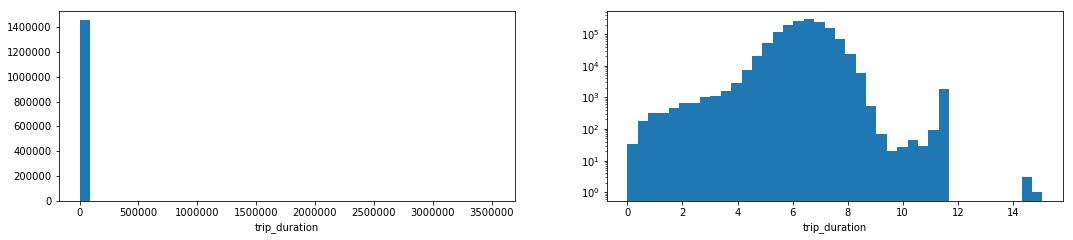

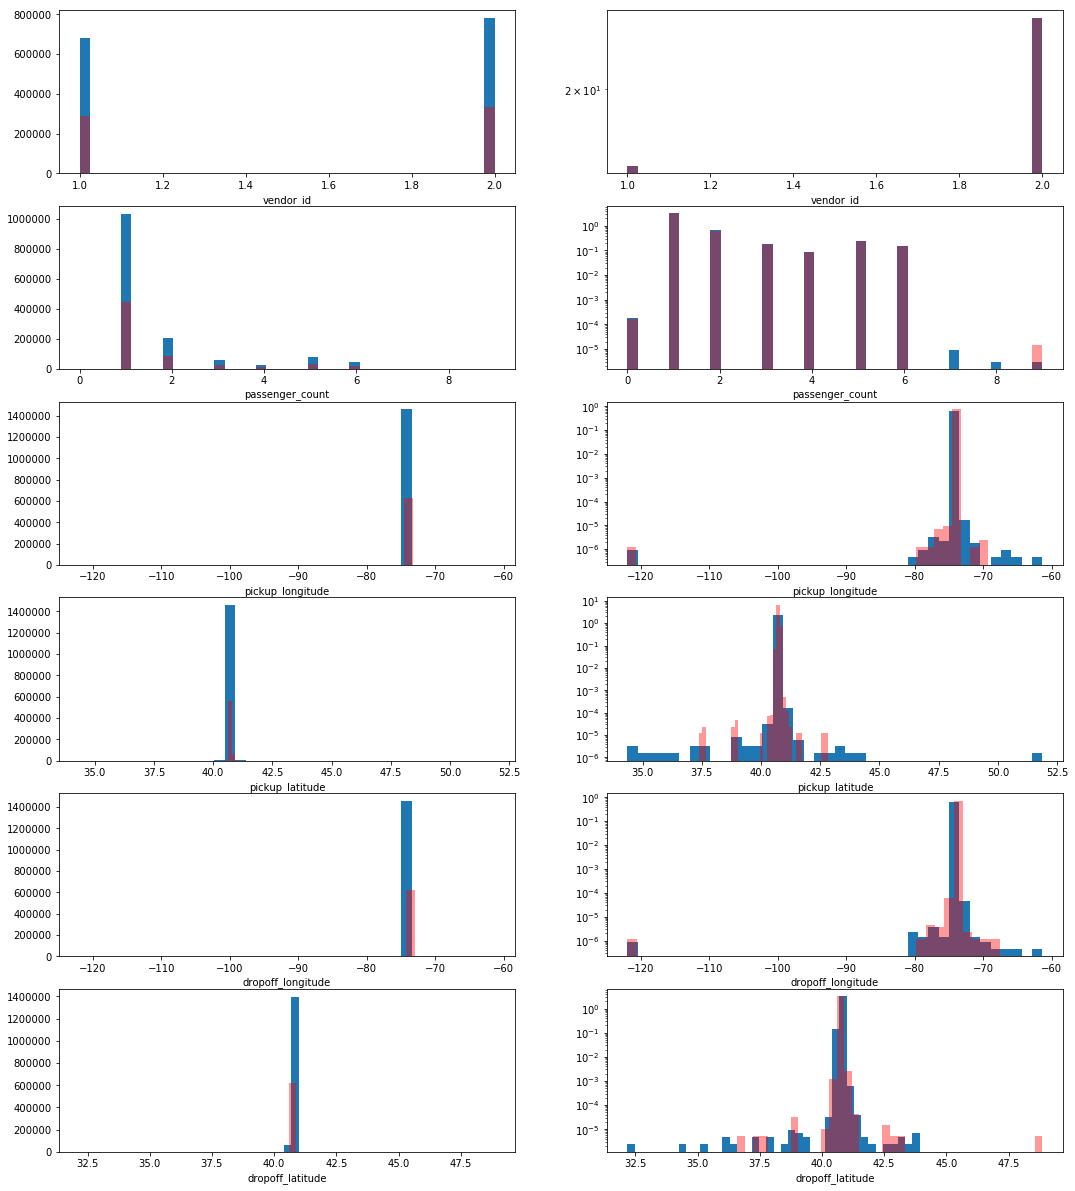

In [8]:
####Feature analysis starts!

####Standard plot
##1-D plot for train/test sets.
#Histogram 
#Tip: data.describe().columns gives all numerical columns.
#Tip: Use log scale to show low population, use 'normed' to compare train/test sets.
#Note the outliers in pickup/dropff coordinates, will handle them later.

import numpy as np
fig, ax = plt.subplots(ncols=2, figsize=(18, 3.5))
ax[0].hist(train.trip_duration, bins=40)
ax[0].set_xlabel('trip_duration')
ax[1].hist(np.log(train.trip_duration),  bins=40, log=True)
ax[1].set_xlabel('trip_duration')

plot_cols = list(test.describe().columns)
n = len(plot_cols)
fig,ax = plt.subplots(nrows=n, ncols=2, figsize=(18,3.5*n))
i = 0
for col in plot_cols:
    ax[i][0].hist(train[col], bins=40)
    ax[i][0].hist(test[col],  bins=40, color='r', alpha=0.4)
    ax[i][1].hist(train[col], bins=40,                       normed=True, log=True)
    ax[i][1].hist(test[col],  bins=40, color='r', alpha=0.4, normed=True, log=True)
    ax[i][0].set_xlabel(col)
    ax[i][1].set_xlabel(col)
    i += 1

(40.63, 40.85)

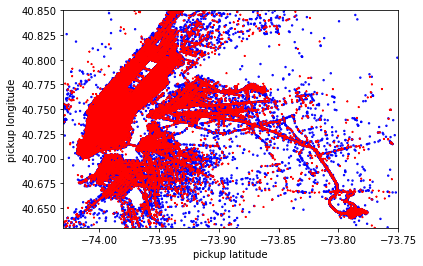

In [18]:
import numpy as np
#2d-plot
#Scatter plot
#A quick google to find the border of NY city
#city_long_border = (-74.03, -73.75), city_lat_border = (40.63, 40.85)
#A quick plot shows the pickup location covers very well the whole city.
#Manhattan and JFK/Laguardia airports are some of the hot spots.
plt.figsize=(10, 8)
plt.scatter(train.pickup_longitude, train.pickup_latitude, 
            s=2, marker='o', edgecolor='b', facecolors='none')
plt.scatter(test.pickup_longitude,  test.pickup_latitude,  
            s=2, marker='*', edgecolor='r', facecolors='none')
            #s=2, color='r', marker='*', alpha=0.7)
plt.xlabel('pickup latitude')
plt.ylabel('pickup longitude')
plt.xlim([-74.03, -73.75])
plt.ylim([40.63, 40.85])

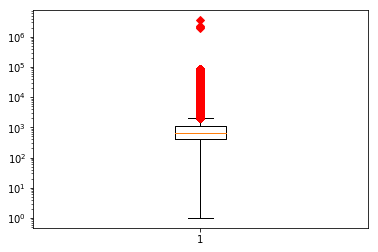

In [33]:
#Boxplots are not effective due to the outliers.
_ = plt.boxplot([train.pickup_longitude, test.pickup_longitude], 0,'rD')
_ = plt.boxplot([train.trip_duration], 0,'rD')
plt.yscale('log')

In [56]:
####Remove Outliers
#Drop data with trip duration outliers, and location outliers.
N_samples = len(train)
train['log_trip_duration'] = np.log(train['trip_duration'])

train = train.loc[train['trip_duration'] <= 86400 ] #max 24 hours
train = train.loc[train['trip_duration'] >= 10] #min 10 seconds
print(train.shape)
#monitor the loss of data
print("{}%".format(round(100*(N_samples-len(train))/N_samples,2)))

#the borders of NY City
#city_long_border = (-74.03, -73.75), city_lat_border = (40.63, 40.85) 
train = train.loc[train['pickup_longitude'] <= -73.75]
train = train.loc[train['pickup_longitude'] >= -74.03]
train = train.loc[train['pickup_latitude']  <=  40.85]
train = train.loc[train['pickup_latitude']  >=  40.63]

train = train.loc[train['dropoff_longitude'] <= -73.75]
train = train.loc[train['dropoff_longitude'] >= -74.03]
train = train.loc[train['dropoff_latitude']  <=  40.85]
train = train.loc[train['dropoff_latitude']  >=  40.63]
print(train.shape)
#monitor the loss of data
print("{}%".format(round(100*(N_samples-len(train))/N_samples,2)))

n_samples = len(test)

test = test.loc[test['pickup_longitude'] <= -73.75]
test = test.loc[test['pickup_longitude'] >= -74.03]
test = test.loc[test['pickup_latitude']  <=  40.85]
test = test.loc[test['pickup_latitude']  >=  40.63]

test = test.loc[test['dropoff_longitude'] <= -73.75]
test = test.loc[test['dropoff_longitude'] >= -74.03]
test = test.loc[test['dropoff_latitude']  <=  40.85]
test = test.loc[test['dropoff_latitude']  >=  40.63]
print(test.shape)
print("{}%".format(round(100*(n_samples-len(test))/n_samples,2)))

(1456656, 12)
0.14%
(1437349, 12)
1.46%
(616934, 9)
1.31%


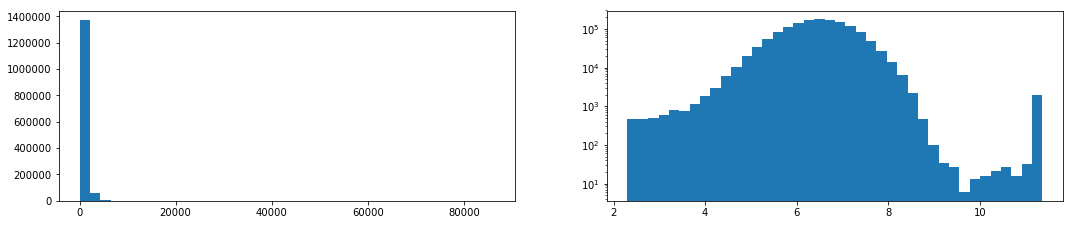

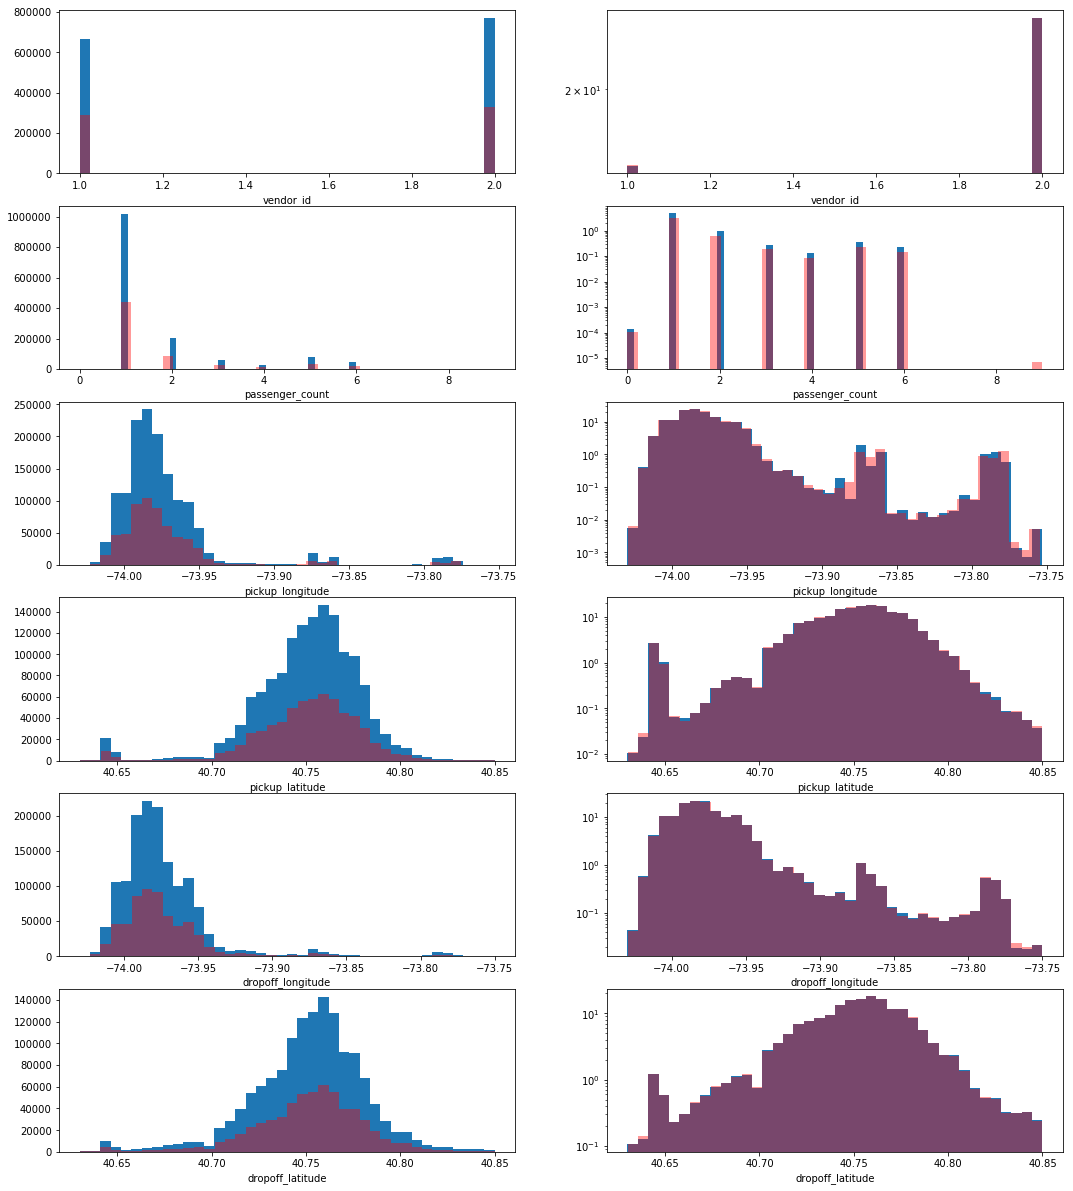

In [57]:
##After drop outliers
##1-D plot
#Histogram of all the numerical columns. Tip: data.describe().columns
#Now much better to see the ditributions.
#Note that the train/test sets have very similar distributions after using 'normed'
import numpy as np

fig, ax = plt.subplots(ncols=2, figsize=(18, 3.5))
ax[0].hist(train.trip_duration, bins=40)
ax[1].hist(np.log(train.trip_duration),  bins=40, log=True)

plot_cols = list(test.describe().columns)
n = len(plot_cols)
fig,ax = plt.subplots(nrows=n, ncols=2, figsize=(18,3.5*n))
i = 0
for col in plot_cols:
    ax[i][0].hist(train[col], bins=40)
    ax[i][0].hist(test[col],  bins=40, color='r', alpha=0.4)
    ax[i][1].hist(train[col], bins=40,                       normed=True, log=True)
    ax[i][1].hist(test[col],  bins=40, color='r', alpha=0.4, normed=True, log=True)
    ax[i][0].set_xlabel(col)
    ax[i][1].set_xlabel(col)
    i += 1

(616934, 9)


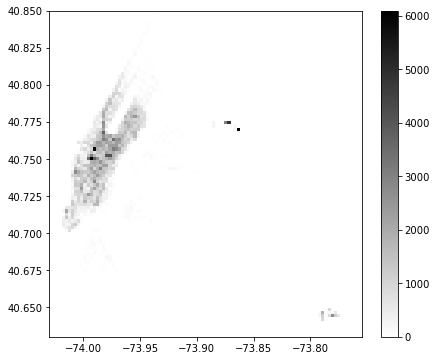

In [64]:
####hist2d
#highlights Manhattan, and the two airports again.
print(test.shape)
plt.figure(figsize=(7,6))
plt.hist2d(test.pickup_longitude, test.pickup_latitude, 
               bins=100, cmap='gray_r')
plt.colorbar()

In [65]:
print("Train:\n{}".format(train.store_and_fwd_flag.value_counts()))
#train_orig.store_and_fwd_flag.value_counts(normalize=True)
print("Test:\n{}".format(test.store_and_fwd_flag.value_counts()))

Train:
N    1429514
Y       7835
Name: store_and_fwd_flag, dtype: int64
Test:
N    613578
Y      3356
Name: store_and_fwd_flag, dtype: int64


In [12]:
# #calculate the distance based on pickup/dropoff location
# from geopy.distance import great_circle
# newport_ri = (41.49008, -71.312796)
# cleveland_oh = (41.499498, -81.695391)
# print(great_circle(newport_ri, cleveland_oh).kilometers)

In [66]:
#Functions for distance calculation
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

(1437349, 15) (616934, 12)


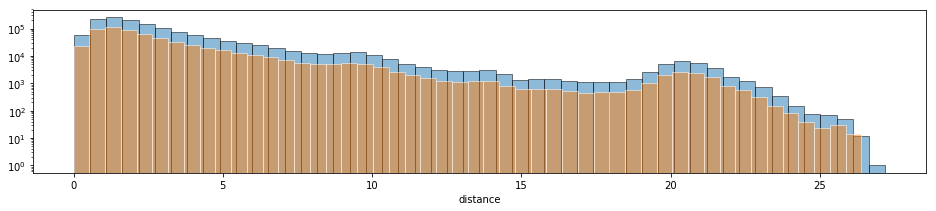

In [67]:
###########################
####Feature Engineering####
###########################
train.loc[:, 'distance_haversine'] = haversine_array(
    train['pickup_latitude'].values, train['pickup_longitude'].values, 
    train['dropoff_latitude'].values,train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(
    test['pickup_latitude'].values,  test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, test['dropoff_longitude'].values)    

train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(
    train['pickup_latitude'].values, train['pickup_longitude'].values, 
    train['dropoff_latitude'].values,train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(
    test['pickup_latitude'].values,  test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(
    train['pickup_latitude'].values, train['pickup_longitude'].values, 
    train['dropoff_latitude'].values,train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(
    test['pickup_latitude'].values,  test['pickup_longitude'].values, 
    test['dropoff_latitude'].values, test['dropoff_longitude'].values)
print(train.shape, test.shape)

plt.figure(figsize=(16,3))
plt.hist(train.distance_haversine, bins=50, log=True, alpha=0.5, edgecolor='k')
plt.hist(test.distance_haversine,  bins=50, log=True, alpha=0.5, edgecolor='w')
plt.xlabel('distance')

In [68]:
###########################
####Feature Engineering####
###########################
#Datetime features
#Pandas: pd.to_datetime(), col.dt(): date, weekday, hour, minute,
import numpy as np
#Convert datetime from type object to type datetimie64
train['pickup_datetime']    = pd.to_datetime(train.pickup_datetime)
train['dropoff_datetime']   = pd.to_datetime(train.dropoff_datetime) #Not in Test
test['pickup_datetime']     = pd.to_datetime(test.pickup_datetime)

#Add new cols
train.loc[:, 'pickup_date']      = train['pickup_datetime'].dt.date
train.loc[:, 'pickup_month']     = train['pickup_datetime'].dt.month
train.loc[:, 'pickup_weekday']   = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour']      = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']
train.loc[:, 'pickup_minute']    = train['pickup_datetime'].dt.minute

test.loc[:, 'pickup_date']      = test['pickup_datetime'].dt.date
test.loc[:, 'pickup_month']     = test['pickup_datetime'].dt.month
test.loc[:, 'pickup_weekday']   = test['pickup_datetime'].dt.weekday
test.loc[:, 'pickup_hour']      = test['pickup_datetime'].dt.hour
test.loc[:, 'pickup_week_hour'] = test['pickup_weekday'] * 24 + train['pickup_hour']
test.loc[:, 'pickup_minute']    = test['pickup_datetime'].dt.minute

train.loc[:,'log_trip_duration'] = np.log(train['trip_duration'] + 1)
train.loc[:,'avg_speed_h'] = 1000 * train['distance_haversine']       / train['trip_duration']
train.loc[:,'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']

base_day = min(train.pickup_date)
assert(base_day == min(test.pickup_date))
train.loc[:,'pickup_day_of_year'] = (train.pickup_date - base_day).dt.days
test.loc[: ,'pickup_day_of_year'] = (test.pickup_date - base_day).dt.days
print(train.shape, test.shape)

(1437349, 24) (616934, 19)


In [69]:
###########################
####Feature Engineering 2##
###########################

#Use clustering separate locations.
#MiniBatchKMeans are much faster than Kmeans for large data without much loss in accuracy.
from sklearn.cluster import MiniBatchKMeans
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values,
                    test[['pickup_latitude', 'pickup_longitude']].values,
                    test[['dropoff_latitude', 'dropoff_longitude']].values))

sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

train.loc[:, 'pickup_cluster']  = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude','dropoff_longitude']])
test.loc[:,  'pickup_cluster']  = kmeans.predict(test[['pickup_latitude',  'pickup_longitude']])
test.loc[:, 'dropoff_cluster']  = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])
print(train.shape, test.shape)

for gby_col in ['pickup_hour', 'pickup_date','pickup_week_hour', 
                'pickup_cluster', 'dropoff_cluster']:
    gby = train.groupby(gby_col).mean()[['avg_speed_h', 'avg_speed_m']]
    gby.columns = ['%s_gby_%s' % (col, gby_col) for col in gby.columns]
    train = pd.merge(train, gby, how='left', left_on=gby_col, right_index=True)
    test  = pd.merge(test,  gby, how='left', left_on=gby_col, right_index=True)

print(train.shape, test.shape)

(1437349, 26) (616934, 21)
(1437349, 36) (616934, 31)


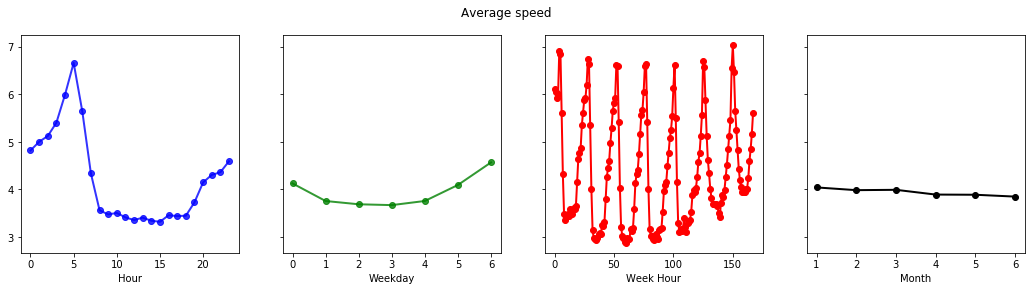

In [70]:
#plot average speed
fig,ax = plt.subplots(ncols=4, sharey=True, figsize=(18,4))
ax[0].plot(train.groupby('pickup_hour').mean()['avg_speed_h'],'bo-',lw=2, alpha=0.8)
ax[0].set_xlabel('Hour')
ax[1].plot(train.groupby('pickup_weekday').mean()['avg_speed_h'],'go-',lw=2, alpha=0.8)
ax[1].set_xlabel('Weekday')
ax[2].plot(train.groupby('pickup_week_hour').mean()['avg_speed_h'],'ro-',lw=2)
ax[2].set_xlabel('Week Hour')
ax[3].plot(train.groupby('pickup_month').mean()['avg_speed_h'], 'ko-',lw=2)
ax[3].set_xlabel('Month')
fig.suptitle('Average speed')

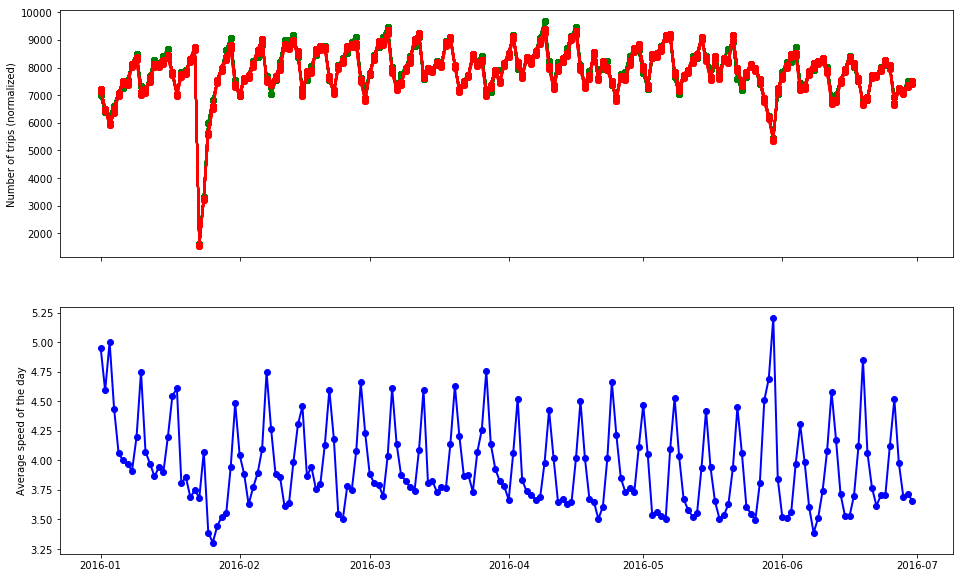

In [71]:
#Note the sudden drop in late January, guess what, there was a huge snow storm that day.
fig,ax=plt.subplots(nrows=2, sharex=True, figsize=(16,10))
ax[0].plot(train.groupby('pickup_date').count(), 'go-', lw=2, label='train')
ax[0].plot(test.groupby('pickup_date').count()/len(test)*len(train), 'ro-', lw=2, label='test')
#ax[0].set_xlabel('Date')
ax[0].set_ylabel('Number of trips (normalized)')
ax[1].plot(train.groupby('pickup_date').mean()['avg_speed_h'], 'bo-', lw=2)
ax[1].set_ylabel('Average speed of the day')

In [72]:
#Convert string values to dummy variables
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test  = pd.get_dummies(test['vendor_id'],  prefix='vi', prefix_sep='_')

store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test  = pd.get_dummies(test['store_and_fwd_flag'],  prefix='sf', prefix_sep='_')

print(vendor_train.shape,vendor_test.shape)
print(store_and_fwd_flag_train.shape,store_and_fwd_flag_test.shape)

(1437349, 2) (616934, 2)
(1437349, 2) (616934, 2)


In [73]:
Train_Master = pd.concat([train, vendor_train, store_and_fwd_flag_train], axis=1)
Test_master  = pd.concat([test,  vendor_test,  store_and_fwd_flag_test],  axis=1)
print(Train_Master.shape,Test_master.shape)
print(Train_Master.columns)

(1437349, 40) (616934, 35)
Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'log_trip_duration', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pickup_date', 'pickup_month',
       'pickup_weekday', 'pickup_hour', 'pickup_week_hour', 'pickup_minute',
       'avg_speed_h', 'avg_speed_m', 'pickup_day_of_year', 'pickup_cluster',
       'dropoff_cluster', 'avg_speed_h_gby_pickup_hour',
       'avg_speed_m_gby_pickup_hour', 'avg_speed_h_gby_pickup_date',
       'avg_speed_m_gby_pickup_date', 'avg_speed_h_gby_pickup_week_hour',
       'avg_speed_m_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster',
       'avg_speed_m_gby_pickup_cluster', 'avg_speed_h_gby_dropoff_cluster',
       'avg_speed_m_gby_dropoff_cluster', 'vi_1', 'vi_2', 'sf_N', 'sf_Y'],
      dtype='object')


In [74]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
train_error = []
valid_error = []
for i in range(7):
    sample_size = (1+i)*20000
    sample_ind = sorted(np.random.permutation(len(Train_Master)))[:sample_size]
    Train, Test = train_test_split(Train_Master.iloc[sample_ind], test_size = 0.2)
    #Train, Test = train_test_split(Train_Master, test_size = 0.2)

    not_for_training_features = [
        'id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime', 'store_and_fwd_flag',
        'trip_duration', 'pickup_date', 'pickup_week_hour', 'pickup_minute', 'log_trip_duration', 
         'avg_speed_h', 'avg_speed_m']

    feature_names = [f for f in Train.columns if f not in not_for_training_features]

    X_train = Train[feature_names]
    Y_train = Train["log_trip_duration"]

    print(X_train.shape, Y_train.shape)

    X_test = Test[feature_names]
    Y_test = Test["log_trip_duration"]

    dtrain = xgb.DMatrix(X_train, Y_train)
    dvalid = xgb.DMatrix(X_test,  Y_test)

    watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
    print("Ready!")

    xgb_pars = {'min_child_weight': 10, 'eta': 0.3, 'colsample_bytree': 0.9, 
                'max_depth': 6,
                'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
                'eval_metric': 'rmse', 'objective': 'reg:linear'}
    train_results = dict()
    model = xgb.train(xgb_pars, dtrain, 500, watchlist, early_stopping_rounds=50,maximize=False,verbose_eval=50,
                     evals_result=train_results)
    print('Round {} Modeling RMSLE {:.5f}'.format(i,model.best_score))
    
    dic1 = train_results['train']
    dic2 = train_results['valid']
    array1 =np.array(str(dic1.values()).split(','))
    array2 =np.array(str(dic2.values()).split(','))
    idx = array2.argsort()
    train_error.append(array1[idx[0]])
    valid_error.append(array2[idx[0]])

/Users/wz12/opt/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


(16000, 28) (16000,)
Ready!
[0]	train-rmse:4.21556	valid-rmse:4.22281
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.295794	valid-rmse:0.461194
Stopping. Best iteration:
[24]	train-rmse:0.3314	valid-rmse:0.459174

Round 0 Modeling RMSLE 0.45917
(32000, 28) (32000,)
Ready!
[0]	train-rmse:4.2165	valid-rmse:4.2247
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.329774	valid-rmse:0.431125
Stopping. Best iteration:
[31]	train-rmse:0.349541	valid-rmse:0.430161

Round 1 Modeling RMSLE 0.43016
(48000, 28) (48000,)
Ready!
[0]	train-rmse:4.22005	valid-rmse:4.22332
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 50 rounds.
[50]	train-rmse:0.345258	valid-rmse:0.401774
Stopping. Best ite

In [75]:
print(valid_error)

[' 0.459174', ' 0.430161', ' 0.399709', ' 0.396051', ' 0.398657', ' 0.406219', ' 0.414062']


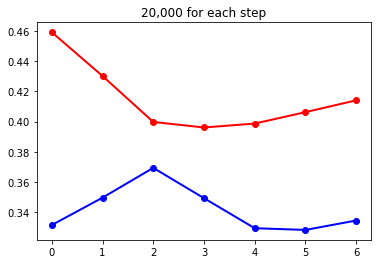

In [78]:
import re
#re.split('; |, ',str)

t_err = [ re.split(" |\]|\)", x)[1] for x in train_error ]
v_err = [ re.split(" |\]|\)", x)[1] for x in valid_error ]

plt.plot(range(7), t_err, 'bo-', lw=2)
plt.plot(range(7), v_err, 'ro-', lw=2)
plt.title('20,000 for each step')

In [ ]:
plt.plot(range(n), train_error, 'bo-', lw=2)
plt.plot(range(n), valid_error, 'ro-', lw=2)
plt.title('20,000 for each step')

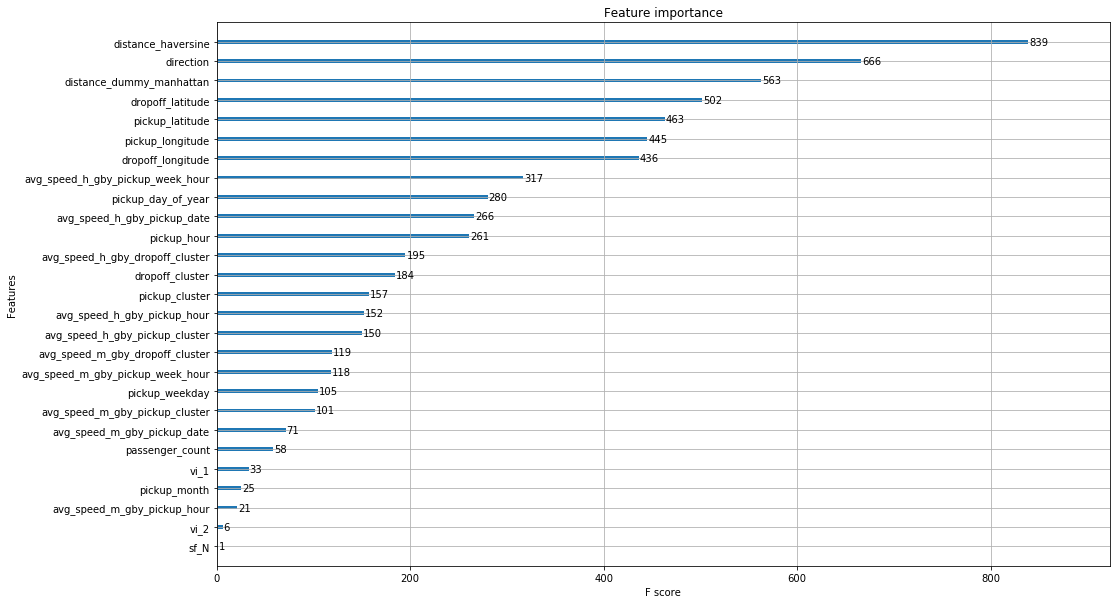

In [79]:
plt.rcParams['figure.figsize'] = [16, 10]
xgb.plot_importance(model, height=0.2)

In [81]:
####Error analysis

Y_pred = model.predict(dvalid)
Test_analysis = X_test.copy()
Test_analysis.loc[:, 'log_trip_duration']      = Y_test
Test_analysis.loc[:, 'pred_log_trip_duration'] = Y_pred
Test_analysis.loc[:, 'error'] = Y_test - Y_pred
Test_analysis.head()

#manual calculation of error
#error = np.sqrt(sum((Y_test - Y_pred)**2)/len(Y_pred))
#print(error)

,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_haversine,distance_dummy_manhattan,direction,pickup_month,pickup_weekday,...,avg_speed_m_gby_pickup_cluster,avg_speed_h_gby_dropoff_cluster,avg_speed_m_gby_dropoff_cluster,vi_1,vi_2,sf_N,sf_Y,log_trip_duration,pred_log_trip_duration,error
732691,1,-73.97692871,40.76468658,-73.98744202,40.76553726,0.89045043,0.98000874,-83.89862978,2,4,...,4.35031382,3.56462634,4.53361220,0,1,1,0,5.77455155,5.63913965,0.13541189
1292256,3,-73.96665955,40.76159286,-73.96899414,40.76838303,0.78021170,0.95165733,-14.59531855,6,0,...,5.48886215,3.26290683,4.28088124,1,0,1,0,5.88887796,5.59103823,0.29783973
360526,1,-73.98002625,40.76521683,-74.00543976,40.73691559,3.80605575,5.28723206,-145.76598577,4,1,...,4.35031382,3.56932180,4.59904996,0,1,1,0,6.56526497,6.94514513,-0.37988016
709205,1,-73.99491882,40.72792053,-73.98612976,40.72948074,0.76065320,0.91410097,76.81324435,2,6,...,4.98675851,3.61859302,4.64291847,0,1,1,0,6.04737218,5.86405039,0.18332179
1334911,1,-73.97310638,40.76200485,-73.96733093,40.76917648,0.93407965,1.28387006,31.37873834,3,3,...,4.66009924,3.26290683,4.28088124,1,0,1,0,5.70711026,5.71506405,-0.00795378


In [88]:
print(Test_analysis.columns)

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'distance_haversine',
       'distance_dummy_manhattan', 'direction', 'pickup_month',
       'pickup_weekday', 'pickup_hour', 'pickup_day_of_year', 'pickup_cluster',
       'dropoff_cluster', 'avg_speed_h_gby_pickup_hour',
       'avg_speed_m_gby_pickup_hour', 'avg_speed_h_gby_pickup_date',
       'avg_speed_m_gby_pickup_date', 'avg_speed_h_gby_pickup_week_hour',
       'avg_speed_m_gby_pickup_week_hour', 'avg_speed_h_gby_pickup_cluster',
       'avg_speed_m_gby_pickup_cluster', 'avg_speed_h_gby_dropoff_cluster',
       'avg_speed_m_gby_dropoff_cluster', 'vi_1', 'vi_2', 'sf_N', 'sf_Y',
       'log_trip_duration', 'pred_log_trip_duration', 'error'],
      dtype='object')


(0, 100)

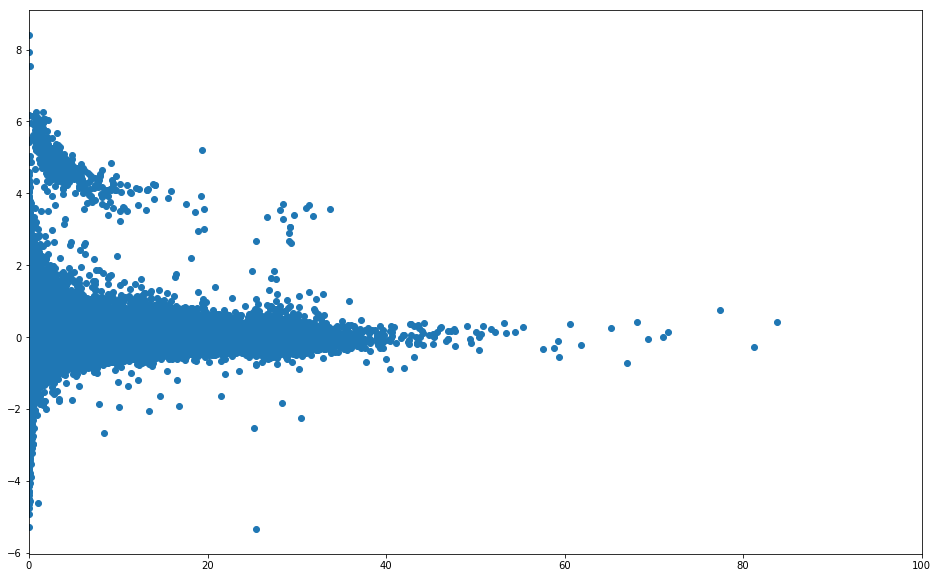

In [100]:
plt.scatter(Test_analysis['distance_dummy_manhattan'], Test_analysis.error)
plt.xlim([0,100])

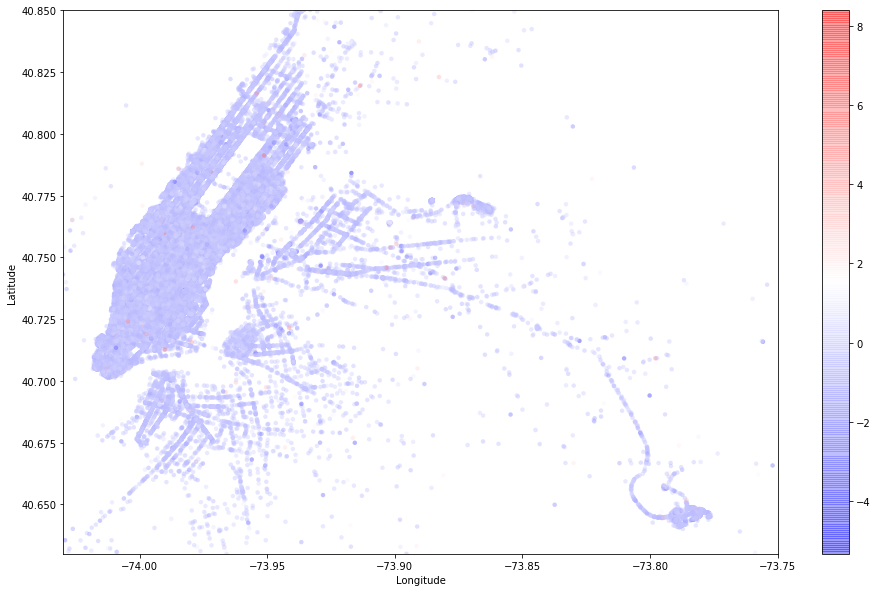

In [113]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=1, nrows=1)
im = ax.scatter(Test_analysis.pickup_longitude.values, Test_analysis.pickup_latitude.values, s=20, lw=0,
           c=Test_analysis.error.values, cmap='bwr', alpha=0.4)
fig.colorbar(im, ax=ax)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

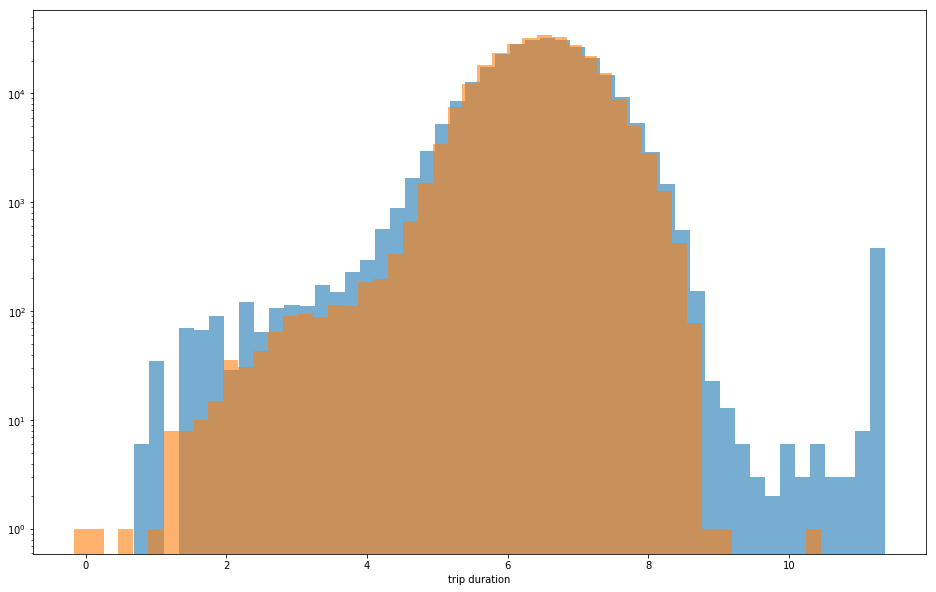

In [94]:
plt.hist(Test_analysis.log_trip_duration, bins=50, log=True, alpha=0.6)
plt.hist(Test_analysis.pred_log_trip_duration, bins=50, log=True, alpha=0.6)
plt.xlabel('trip duration')

In [ ]:
#PCA
#No significant effect

# from sklearn.decomposition import PCA
# train = train_orig
# test  = test_orig

# coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
#                     train[['dropoff_latitude', 'dropoff_longitude']].values,
#                     test[['pickup_latitude', 'pickup_longitude']].values,
#                     test[['dropoff_latitude', 'dropoff_longitude']].values))

# pca = PCA().fit(coords)

# train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
# train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
# train['dropoff_pca0']= pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
# train['dropoff_pca1']= pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

# test['pickup_pca0'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 0]
# test['pickup_pca1'] = pca.transform(test[['pickup_latitude', 'pickup_longitude']])[:, 1]
# test['dropoff_pca0']= pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
# test['dropoff_pca1']= pca.transform(test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
# print(train.shape, test.shape)

# train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) +\
#                                 np.abs(train['dropoff_pca0'] - train['pickup_pca0'])
# test.loc[:, 'pca_manhattan'] =  np.abs(test['dropoff_pca1']  - test['pickup_pca1']) +\
#                                 np.abs(test['dropoff_pca0'] - test['pickup_pca0'])

# train.loc[:, 'center_latitude']  = (train['pickup_latitude'].values + train['dropoff_latitude'].values) / 2
# train.loc[:, 'center_longitude'] = (train['pickup_longitude'].values + train['dropoff_longitude'].values) / 2
# test.loc[:, 'center_latitude']  = (test['pickup_latitude'].values + test['dropoff_latitude'].values) / 2
# test.loc[:, 'center_longitude'] = (test['pickup_longitude'].values + test['dropoff_longitude'].values) / 2

# print(train.shape, test.shape)

In [ ]:
##Use some external data from previous Kaggle NY Taxi competitions
# fr1 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_1.csv', 
#                   usecols=['id', 'total_distance', 'total_travel_time',  'number_of_steps'])
# fr2 = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_train_part_2.csv', 
#                   usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])
# test_street_info = pd.read_csv('input/new-york-city-taxi-with-osrm/fastest_routes_test.csv',
#                   usecols=['id', 'total_distance', 'total_travel_time', 'number_of_steps'])

# train_street_info = pd.concat((fr1, fr2))

# train = train.merge(train_street_info, how='left', on='id')
# test  = test.merge(test_street_info,   how='left', on='id')

# print(train.shape, test.shape)

In [ ]:
%%time
##Hyperparameter tuning

md = [4, 6, 8]
lr = [0.1,0.3,0.5]
mcw = [5,10,20,30]
score_list = []
####Booster parameters
#eta: learning rate  df=0.3, rg 0.01-0.2
#min_child_weight    df=1,            control overfitting, use CV to tune
#max_depth           df=6,   rg=3-10, control overfitting, use CV to tune
#gamma               df=0,            minimum reduction in loss function required for splitting     
#subsample           df=1    rg=0.5-1 The fraction of columns to be random samples for each tree
#lambda              df=1             L2 regularization (as in Ridge regression)
#alpha               df=0             L1 regularization (as in Lasso regression)

####Learning task parameters
#objective           df=reg:linear, the loss function, others: binary:logistic, multi:softprob, 
for m in md:
    for l in lr:
        for n in mcw:
            #t0 = datetime.now()
            xgb_pars = {'min_child_weight': n, 'eta': l, 'colsample_bytree': 0.9, 
                       'max_depth': m,
           'subsample': 0.9, 'lambda': 1., 'nthread': -1, 'booster' : 'gbtree', 'silent': 1,
           'eval_metric': 'rmse', 'objective': 'reg:linear'}
            model = xgb.train(xgb_pars, dtrain, 100, watchlist, early_stopping_rounds=40,
                 maximize=False, verbose_eval=10)
            score_list.append([model.best_score,m,l,n])
            print('Modeling RMSLE {:.5f}, md={}, eta={}, mcw={}'.format(model.best_score, m,l,n))

In [ ]:
# %%time
# #Production Run
# xgb_pars = {'min_child_weight': 20, 'eta': 0.3, 'colsample_bytree': 0.9, 
#             'max_depth': 8,
#             'subsample': 0.9, 'lambda': 1, 'booster' : 'gbtree', 'silent': 1,
#             'eval_metric': 'rmse', 'objective': 'reg:linear'}
# model = xgb.train(xgb_pars, dtrain, 1000, watchlist, early_stopping_rounds=50,maximize=False,verbose_eval=100)
# print('Modeling RMSLE %.5f' % model.best_score)

# pred = model.predict(dtest)
# pred = np.exp(pred)
# submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
# submission.columns = ['id','trip_duration']
# submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
# submission.to_csv("submission_zheng_2.csv", index=False)